In [1]:
import os
import sys
import time
import argparse
import random

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score

from torch.distributions.binomial import Binomial
from torch.distributions.bernoulli import Bernoulli
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import DataCollatorForLanguageModeling, BertForMaskedLM, BertModel
from transformers import Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup, AdamW

from tokens import WordLevelBertTokenizer
from vocab import create_vocab
from data import CausalBertRealDataset
from utils import DATA_PATH, make_dirs
from causal_bert_real import CausalBOW, CausalBert, load_data, est_casual_effect
from causal_tokens import *

In [2]:
def true_casual_effect(data_loader, effect='ate', estimation='q'):
    assert estimation == 'q', f'unallowed estimation: {estimation}'
    
    dataset = data_loader.dataset
    
    Q1 = dataset.treatment * dataset.response + (1 - dataset.treatment) * dataset.pseudo_response
    Q1 = Q1.cpu().data.numpy().squeeze()

    Q0 = dataset.treatment * dataset.pseudo_response + (1 - dataset.treatment) * dataset.response
    Q0 = Q0.cpu().data.numpy().squeeze()

    treatment = dataset.treatment.cpu().data.numpy().squeeze()
    prop_scores = dataset.prop_scores.cpu().data.numpy().squeeze()
    
    if estimation == 'q':
        if effect == 'att':
            phi = (treatment * (Q1 - Q0))
            return phi.sum() / treatment.sum()
        elif effect == 'ate':
            return (Q1 - Q0).mean()
        
    elif estimation == 'plugin':
        phi = (prop_scores * (Q1 - Q0)).mean()
        if effect == 'att':
            return phi / treatment.mean()
        elif effect == 'ate': 
            return phi

In [3]:
trained = '/nfs/turbo/lsa-regier/bert-results/results/casualmodel/realdata/[FINAL]_[back-painkiller]_C-BERT_64_20.pth'
trained = '/nfs/turbo/lsa-regier/bert-results/results/casualmodel/realdata/[BEST]_[back-painkiller]_C-BERT_64_30.pth'

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '7'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
model = torch.load(trained).to(device)

In [5]:
pretreat_tokens = BACKPAIN_DIAG_TOKENS
treat_tokens = BACKPAIN_PROC_TOKENS
response_tokens = PAINKILLER_TOKENS

train_loader, test_loader = load_data(pretreat_tokens, treat_tokens, response_tokens, 16, device=device)

unadjust = (test_loader.dataset.responses[test_loader.dataset.treatments == 1].mean() -
                test_loader.dataset.responses[test_loader.dataset.treatments == 0].mean()).item()
print(f'Unadjusted: [value: {unadjust:.4f}]')

Load training set in 42.15 sec
Training set: [treated: 0.0145], Training set: [response: 0.2111]
Load validation set in 39.40 sec
Validation set: [treated: 0.0140], Validation set: [response: 0.2128]
****************************************************************************************************
Unadjusted: [value: -0.0370]


In [6]:
prop_scores = []

treatments = []
responses = []

tokens = []
model.eval()
for idx, (token, treatment, response) in enumerate(test_loader):
    prop_score, _, _ = model(token)
    if model.prop_is_logit:
        sigmoid = nn.Sigmoid()
        prop_score = sigmoid(prop_score)
    prop_scores.append(prop_score.cpu().data.numpy().squeeze())
    treatments.append(treatment.cpu().data.numpy().squeeze())
    responses.append(response.cpu().data.numpy().squeeze())
    tokens.append(token.cpu().data.numpy().squeeze())
    
prop_scores = np.concatenate(prop_scores, axis=0)
treatments = np.concatenate(treatments, axis=0)
responses = np.concatenate(responses, axis=0)
tokens = np.concatenate(tokens, axis=0)

In [7]:
# est ATT
t1 = responses[treatments == 1].mean()

w = prop_scores / (1 - prop_scores)
t0 = (w[treatments == 0] * responses[treatments == 0]).sum() / (w[treatments == 0]).sum()

t1 - t0

0.040763125

In [8]:
w_ate = treatments / prop_scores + (1 - treatments) / (1 - prop_scores)
w_att = treatments + (1 - treatments) * prop_scores / (1 - prop_scores)

In [9]:
# def est_effect(responses, treatments, prop_scores, outlier=None):
    
#     if outlier:
#         responses = responses[(prop_scores > outlier) & (prop_scores < 1 - outlier)]
#         treatments = treatments[(prop_scores > outlier) & (prop_scores < 1 - outlier)]
#         prop_scores = prop_scores[(prop_scores > outlier) & (prop_scores < 1 - outlier)]

#     e1 = responses[treatments == 1] / prop_scores[treatments == 1]
#     e0 = responses[treatments == 0] / ( 1 - prop_scores[treatments == 0])
        
#     return e1.mean() - e0.mean()


def est_effect(responses, treatments, prop_scores, est, outlier=None):
    
    if outlier:
        responses = responses[(prop_scores > outlier) & (prop_scores < 1 - outlier)]
        treatments = treatments[(prop_scores > outlier) & (prop_scores < 1 - outlier)]
        prop_scores = prop_scores[(prop_scores > outlier) & (prop_scores < 1 - outlier)]

    w_ate = treatments / prop_scores + (1 - treatments) / (1 - prop_scores)
    w_att = treatments + (1 - treatments) * prop_scores / (1 - prop_scores)

    if est == 'ate':
        w = w_ate
    else:
        w = w_att
    e1 = (responses * treatments * w).sum() / (treatments * w).sum()
    e2 = (responses * (1 - treatments) * w).sum() / ((1 - treatments) * w).sum()
    
    return e1 - e2

In [10]:
est_effect(responses, treatments, prop_scores, 'ate')

-0.03280212

In [11]:
est_effect(responses, treatments, prop_scores, 'att')

0.04076311

In [57]:
responses[treatments == 1].mean() - responses[treatments == 0].mean()

-0.04500486

In [58]:
(responses[treatments == 1] / prop_scores[treatments == 1]).mean()

18.157457

In [59]:
(responses[treatments == 0] / (1 - prop_scores[treatments == 0])).mean()

0.21641535

In [26]:
roc_auc_score(treatments, prop_scores)

0.9822436490774937

In [28]:
treatments.shape

(48096,)

In [19]:
treatments.sum()

582.0

In [22]:
responses.sum()

10237.0

Text(0, 0.5, 'Predicted propensity scores')

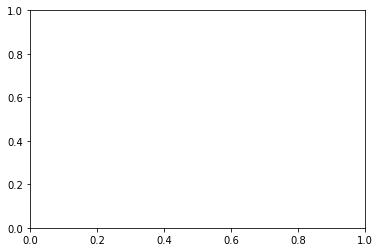

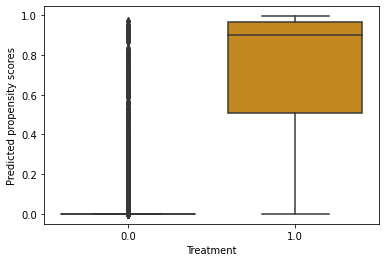

In [12]:
dat = np.array([treatments, prop_scores]).T
dat = pd.DataFrame(dat, columns=['treatments', 'pred_prop_scores'])

plt.cla()
fig = plt.figure()
ax = fig.add_subplot(111)
_ = sns.boxplot(y='pred_prop_scores', x='treatments', data=dat, palette="colorblind", )
ax.set_xlabel('Treatment')
ax.set_ylabel('Predicted propensity scores')

In [30]:
prop_scores[treatments == 0].max()

0.97244376

In [31]:
prop_scores[treatments == 0].min()

8.120827e-05

In [7]:
vocab = create_vocab(merged=True, uni_diag=True)
tokenizer = WordLevelBertTokenizer(vocab)

In [27]:
tokenizer

In [88]:
bug_influent = 0
for i in range(tokens.shape[0]):
    raw_seq = tokenizer.decode(tokens[i])
    if 'diag:J45' not in raw_seq:
        if abs(real_prop_scores[i] - 0.8) < 0.1:
            bug_influent += 1

In [90]:
bug_influent

16

In [87]:
i

191759

In [95]:
len(special)

819

In [96]:
# special = []
# real_p = []
# p = []
# for i in range(tokens.shape[0]):
#     if abs(prop_scores[i] - real_prop_scores[i]) > 0.1:
#         raw_seq = tokenizer.decode(tokens[i])
        
#         print(f'[real: {real_prop_scores[i]:.2f}] - [predict: {prop_scores[i]:.4f}]')
#         print(raw_seq)
#         if 'diag:J45' not in raw_seq and abs(real_prop_scores[i] - 0.8) < 0.1:
#             print('find bug')
# #             break
#         print('-' * 300)
        
#         special.append(raw_seq)
#         real_p.append(round(real_prop_scores[i], 2))
#         p.append(round(prop_scores[i], 2))

# print('finish')

In [98]:
r = responses[abs(prop_scores - real_prop_scores) < 0.1]
t = treatments[abs(prop_scores - real_prop_scores) < 0.1]
p = prop_scores[abs(prop_scores - real_prop_scores) < 0.1]

t1 = r[t == 1].mean()

w = p / (1 - p)
t0 = (w[t == 0] * r[t == 0]).sum() / (w[t == 0]).sum()

t1 - t0

0.122840226

In [102]:
r = np.concatenate([responses[abs(prop_scores - real_prop_scores) < 1], responses[abs(prop_scores - real_prop_scores) >= 1]], axis=0)
t = np.concatenate([treatments[abs(prop_scores - real_prop_scores) < 1], treatments[abs(prop_scores - real_prop_scores) >= 1]], axis=0)
p = np.concatenate([prop_scores[abs(prop_scores - real_prop_scores) < 1], real_prop_scores[abs(prop_scores - real_prop_scores) >= 1]], axis=0)

t1 = r[t == 1].mean()

w = p / (1 - p)
t0 = (w[t == 0] * r[t == 0]).sum() / (w[t == 0]).sum()

t1 - t0

0.12355143

In [106]:
print(f'Real: [0.8], Est: [{prop_scores[real_prop_scores > 0.5].mean():.4f}({prop_scores[real_prop_scores > 0.5].std():.4f})]')
print(f'Real: [0.2], Est: [{prop_scores[real_prop_scores < 0.5].mean():.4f}({prop_scores[real_prop_scores < 0.5].std():.4f})]')


Real: [0.8], Est: [0.8068(0.0307)]
Real: [0.8], Est: [0.1870(0.0319)]


0.13526529

Text(0, 0.5, 'Predicted propensity scores')

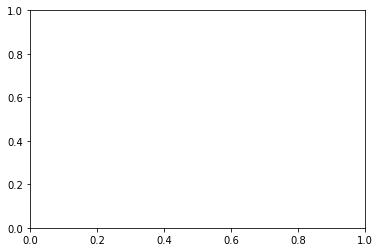

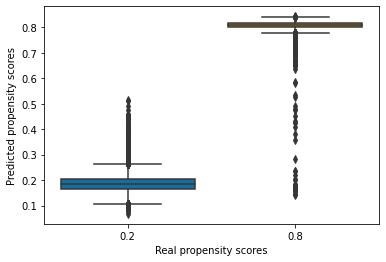

In [9]:
dat = np.array([real_prop_scores, prop_scores]).T
dat = pd.DataFrame(dat, columns=['real_prop_scores', 'pred_prop_scores'])

plt.cla()
fig = plt.figure()
ax = fig.add_subplot(111)
_ = sns.boxplot(y='pred_prop_scores', x='real_prop_scores', data=dat, palette="colorblind", )
ax.set_xlabel('Real propensity scores')
ax.set_ylabel('Predicted propensity scores')

In [10]:
# att_p = est_casual_effect(test, model, 'att', 'q', evaluate=False)[0]
# print(att_p)

In [12]:
att_plugin = est_casual_effect(test, model, 'att', 'plugin', evaluate=False)[0]
print(att_plugin)

KeyboardInterrupt: 

In [11]:
att_plugin = est_casual_effect(test, model, 'att', 'plugin', evaluate=False)[0]
print(att_plugin)

0.10595347


In [ ]:

t1 = responses[treatments == 1].mean()

w = real_prop_scores / (1 - real_prop_scores)
t0 = (w[treatments == 0] * responses[treatments == 0]).sum() / (w[treatments == 0]).sum()

t1 - t0

In [115]:
rs = test.dataset.response
ts = test.dataset.treatment
ps = test.dataset.prop_scores

t1 = rs[ts==1].mean()

w = ps / (1 - ps)

t0 = (w[ts == 0] * rs[ts == 0]).sum() / (w[ts == 0]).sum()
t1 - t0

tensor(0.1353, device='cuda:0')